### Feature engineering:
  \- [Polynomials of strong features](#Polynomials-of-strong-features)  <br/>
  \- [Log of skewed features](#Log-of-skewed-features) <br/>
  \- [Remove low var features](#Remove-low-var-features) <br/>
  \- [Reduce levels of categorical features](#Apply-transformations) <br/>
  \- [One-hot-encoding](#Apply-transformations) <br/>
  \- [Make 2-level categorical features booleans](#Apply-transformations) <br/>
  \- [Normalize_features](#Apply-transformations) <br/>
  \+ [PCA of correlated features](#Apply-transformations) <br/>
  \+ [Retrieve hidden meaning from categorical data](#Apply-transformations) <br/>
  \+ [Sum up boolean columns](#Apply-transformations) <br/>
  \+ [Replace NA with means](#Apply-transformations) <br/>
  \+ [Sum up boolean columns](#Apply-transformations) <br/>
  \+ [Lasso features](#Lasso-features) <br/>
  \+ [Offsests](#Find-offsets-using-fmin_powell) <br/>
  
    

### Algorithms:
  \+\+ [GradientBoostingRegressor](#GradientBoostingRegressor)  <br/>
  \+ [XGBoost](#XGBoost)  <br/>
  \- [RidgeCV](#RidgeCV)  <br/>
  \- [RandomForestRegressor](#RandomForestRegressor)  <br/>
  \- [Lasso](#Lasso)  <br/>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew
%matplotlib inline

from __future__ import division

In [14]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from ml_metrics import quadratic_weighted_kappa
from sklearn.grid_search import GridSearchCV

### Useful functions

In [15]:
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

def get_1h_map(data, cols):
    one_hot_dict = {}
    for col in cols:
        unique_vals = np.array( pd.Series(data.loc[:, col].unique()).dropna() )
        one_hot_dict[col] = unique_vals
    return one_hot_dict

def one_hot_encode(data, one_hot_cols):
    for col, vals in one_hot_cols.iteritems():
        for unique_val in vals:
            data.loc[:, col + '_' + str(unique_val)] = data.loc[:, col].isin([unique_val])
        data = data.drop(col, axis=1)
    return data

def get_polynomials(data, features, power):
    for col in features:
        data.loc[:, col + '_squared'] = data[col].apply(lambda x: x**power)
    return data

# maps all rare categorical levels to a single level (string)
def get_reduced_freq_map(dataset, feature, freq_threshold):
    freq_map = {}
    val_count = len(dataset[feature])
    for a, b in dataset[feature].value_counts().iteritems():
        freq_map[a] = b / val_count

    freq_rate_map = {}
    for k, v in freq_map.iteritems():
        if v < freq_threshold:
            freq_rate_map[k] = feature + '_low'

    return freq_rate_map

def make_binary(data, bool_not_binary):
    # mapping twice since 'Replacement not allowed with overlapping keys and values'
    bool_mapping = {}
    for col in bool_not_binary:
        unique_vals = np.array( pd.Series(data[col].unique()).dropna() )
        mapping = {unique_vals[0]: '0', unique_vals[1]: '1'}
        if mapping: bool_mapping[col] = mapping          
    data = data.replace(bool_mapping)
    bool_mapping = {'0': 0, '1': 1}
    data = data.replace(bool_mapping)
    return data

def is_normalized(col):
    return max(col) <= 1 and min(col) >= 0

def normalize_features(data, features): # works for positive values
    for col in features:
        if not is_normalized(data.loc[:, col]):
            print col
            data.loc[:, col] = normalize([data.loc[:, col]])[0] 
    return data

def factorize_pr_info_2(data):
    data.loc[:, 'Product_Info_2_let'] = pd.factorize(data.loc[:, 'Product_Info_2'].str[0])[0]
    data.loc[:, 'Product_Info_2_num'] = pd.factorize(data.loc[:, 'Product_Info_2'].str[1])[0]
    data.loc[:, 'Product_Info_2']     = pd.factorize(data.loc[:, 'Product_Info_2'])[0]
    return data

def sum_bool_cols(data, starts_with):
    column_names = data.columns[data.columns.str.startswith(starts_with)]
    data.loc[:, starts_with + '_Sum'] = data.loc[:, column_names].sum(axis=1)
    return data

def offset_data(predictions, offsets):
    offsets = dict(zip(range(1, 9), offsets))
    offset_predictions = []
    for pred in predictions:
        pred_int = np.round(pred).astype(int) 
        if pred_int in offsets:
            offset_predictions.append(pred + offsets[pred_int])
        else:
            offset_predictions.append(pred)   
    return offset_predictions

def clip_data(predictions, minimum, maximum):
    preds_rnd = np.round(predictions)
    final_preds = np.clip(preds_rnd, minimum, maximum)
    return final_preds.astype(int)
    
def score_data(final_preds, labels):
    # κ tends to underestimate the agreement on the rare category
    return quadratic_weighted_kappa(final_preds, labels)

def PCA_features(data, features, pca, scaler, drop_orig=True):
    features_combo = data.loc[:, features]
    features_combo = pca.fit_transform(features_combo.fillna(features_combo.mean())) 

    features_combo = scaler.fit_transform(features_combo)
    features_combo = normalize([features_combo.flatten()], copy=True)

    pca_col_name = '_'.join(['PCA'] + features)
    data.loc[:, pca_col_name] = features_combo[0]
    
    if drop_orig:
        data = data.drop(features, axis=1)

    return data

In [16]:
dataset_raw = pd.read_csv("train.csv") 
dataset = dataset_raw.copy()

In [17]:
dataset = dataset.drop('Id', axis=1)

### Explore Data

In [18]:
type(dataset['Response'][0])

numpy.int64

In [19]:
print len(dataset), 'by', len(list(dataset))

59381 by 127


In [20]:
# copied from 'Get the Data' section on Kaggle
categorical_feat_str = 'Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41'

categorical_features = [col.strip() for col in categorical_feat_str.split(',')]
numerical_features = [col for col in list(dataset) if col not in categorical_features and len(dataset[col].unique()) != 2]
numerical_and_bool_features = [col for col in list(dataset) if col not in categorical_features]
numerical_features_no_label = filter(lambda x: x != 'Response', numerical_features)

In [21]:
groups = ['Product_Info', 'Employment_Info', 'InsuredInfo', 'Insurance_History', 'Family_Hist', 'Medical_History', 'Medical_Keyword']

In [22]:
high_NA_features = []
bool_not_binary = []
need_normalization = []

In [23]:
col_notes = {
    'Id': 'useless',
    'BMI': 'Wt/Ht^2',
    'Response': 'target'}

d = {'NAME': [], 
     'MIN': [], 
     'MAX': [], 
     'NULLS': [], 
     'TYPE_int': [], # type intended
     'TYPE_act': [], # actual type in raw data
     'UNIQUE': [],
     'NOTES': []}

dataset_len = len(dataset)

for col in list(dataset):    
    unique_values = np.array(pd.Series(dataset[col].unique()).dropna())
    minimum = unique_values[0] if (isinstance(unique_values[0], str)) else np.min(unique_values)
    maximum = unique_values[1] if (isinstance(unique_values[1], str)) else np.max(unique_values)
  
    num_unique = len(dataset[col].unique())
    tp_int = 'category' if col in categorical_features else 'number'
    tp_act = 'category' if (isinstance(minimum, str)) else 'number'
    nulls_float = dataset[col].isnull().sum() / dataset_len
    nulls = str(nulls_float*100)[:4] + '%'
    note = col_notes[col] if col in col_notes else '---'
    note = 'boolean' if num_unique == 2 else note
    note = 'high NA' if (nulls_float > 0.7) else note
    
    if (nulls_float > 0.7):
        high_NA_features.append(col)
        
    if (num_unique == 2 and sum(dataset[col].unique()) != 1):
        bool_not_binary.append(col)
    
    if 'Medical_History' in col and tp_int == 'number':
        need_normalization.append(col)
    
    
    d['NAME']     = d['NAME']     + [col]
    d['MIN']      = d['MIN']      + [minimum]
    d['MAX']      = d['MAX']      + [maximum]
    d['NULLS']    = d['NULLS']    + [nulls]
    d['TYPE_int'] = d['TYPE_int'] + [tp_int]
    d['TYPE_act'] = d['TYPE_act'] + [tp_act]
    d['UNIQUE']   = d['UNIQUE']   + [num_unique]
    d['NOTES']    = d['NOTES']    + [note]
    
with pd.option_context('display.max_rows', len(d['NAME']), 'expand_frame_repr', False):
    print pd.DataFrame(d)[['NAME', 'TYPE_int', 'TYPE_act', 'MIN', 'MAX', 'UNIQUE', 'NULLS', 'NOTES']]

                    NAME  TYPE_int  TYPE_act MIN       MAX  UNIQUE  NULLS    NOTES
0         Product_Info_1  category    number   1         2       2   0.0%  boolean
1         Product_Info_2  category  category  D3        A1      19   0.0%      ---
2         Product_Info_3  category    number   1        38      34   0.0%      ---
3         Product_Info_4    number    number   0         1    1491   0.0%      ---
4         Product_Info_5  category    number   2         3       2   0.0%  boolean
5         Product_Info_6  category    number   1         3       2   0.0%  boolean
6         Product_Info_7  category    number   1         3       3   0.0%      ---
7                Ins_Age    number    number   0         1      65   0.0%      ---
8                     Ht    number    number   0         1      39   0.0%      ---
9                     Wt    number    number   0         1     300   0.0%      ---
10                   BMI    number    number   0         1    3256   0.0%  Wt/Ht^2
11  

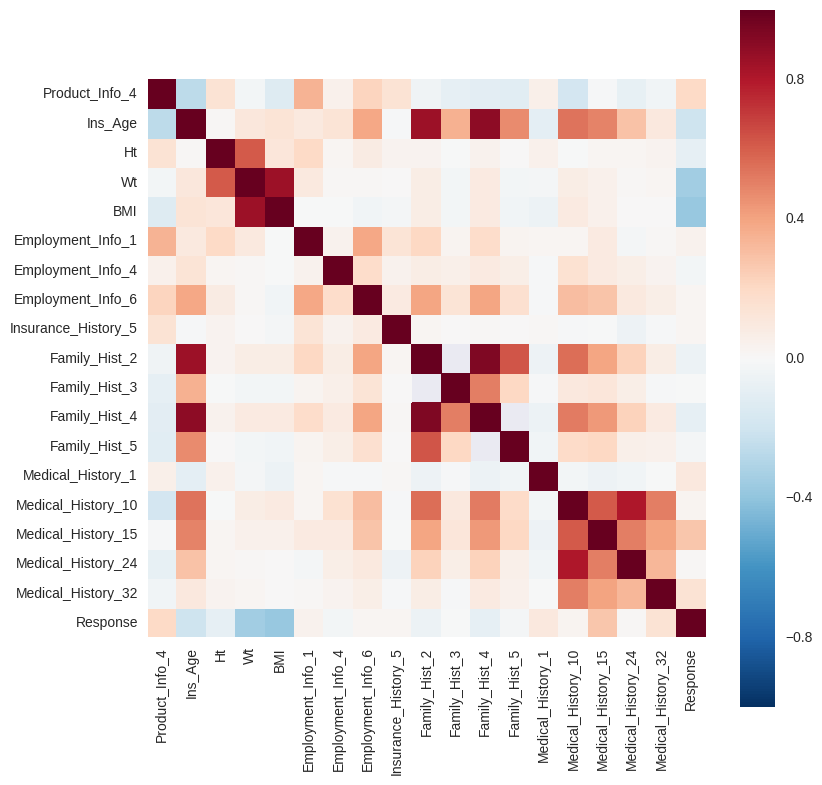

In [24]:
corr = dataset[numerical_features].corr()

plt.figure(figsize=(9,9))
sns.heatmap(corr, vmax=1, square=True)

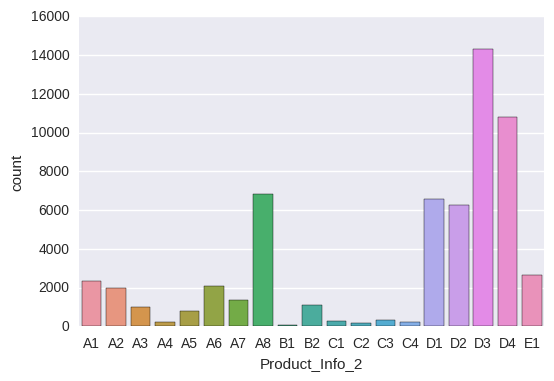

In [25]:
sns.countplot(x='Product_Info_2', data=dataset, order=sorted(set(dataset['Product_Info_2'])))

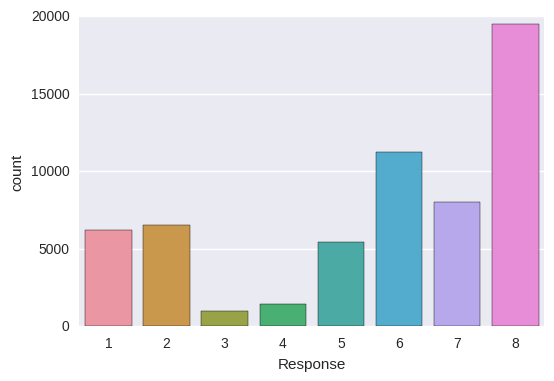

In [26]:
sns.countplot(x='Response', data=dataset)

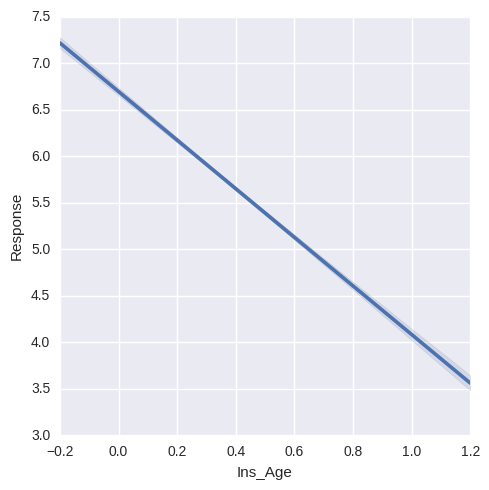

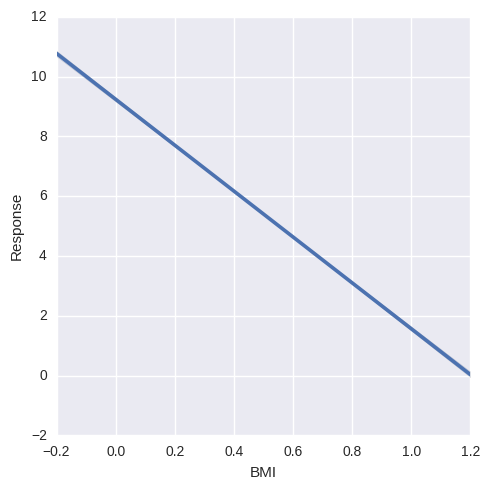

In [27]:
sns.lmplot(x='Ins_Age', y='Response', data=dataset, scatter=False)
sns.lmplot(x='BMI', y='Response', data=dataset, scatter=False)

### Polynomials of strong features

In [28]:
label_corr = np.abs(corr['Response'])
label_corr = label_corr[label_corr > 0.3]
label_corr = label_corr.sort_values(ascending=False)[1:]
label_corr = np.array(label_corr.index)
label_corr

array(['BMI', 'Wt'], dtype=object)

### DEMO: PCA with sklearn

In [29]:
from sklearn.decomposition import PCA

_train_x_ = np.array([[1,1], [2, 2], [3, 3]])
_test_x_  = np.array([[1,1], [2, 2], [3, 3]])

pca = PCA(n_components=1) # reduce to one feature
_pca_train_x_ = pca.fit_transform(_train_x_)
_pca_test_x_  = pca.transform(_test_x_)

print 'correlation:', pd.DataFrame(_train_x_).corr()[0][1]
print _train_x_
print _pca_train_x_
print 'var explained:', pca.explained_variance_

correlation: 1.0
[[1 1]
 [2 2]
 [3 3]]
[[-1.41421356]
 [ 0.        ]
 [ 1.41421356]]
var explained: [ 1.33333333]


In [30]:
_train_x_ = np.array([[-8, -1], [-12, 2], [0, 7]])
_test_x_  = np.array([[-1, -2], [2, 2], [4, 6]])

pca = PCA(n_components=1)
_pca_train_x_ = pca.fit_transform(_train_x_)
_pca_test_x_  = pca.transform(_test_x_)

print 'correlation:', pd.DataFrame(_train_x_).corr()[0][1]
print _train_x_
print _pca_train_x_
print 'var explained:', pca.explained_variance_

correlation: 0.755928946018
[[ -8  -1]
 [-12   2]
 [  0   7]]
[[-3.00204761]
 [-4.94034787]
 [ 7.94239547]]
var explained: [ 32.16699092]


### Split data

In [166]:
from sklearn.model_selection import train_test_split

x = dataset.drop('Response', axis=1)
y = dataset.loc[:, 'Response']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

### Log of skewed features

In [32]:
# col_skewness = [skew(x_train[col].dropna()) for col in numerical_features_no_label]
# skewed_features = [feature for sk, feature in zip(col_skewness, numerical_features_no_label) if sk > 0.75]
# dataset[skewed_features] = np.log1p(dataset[skewed_features])

### Remove low var features

In [33]:
# from sklearn.feature_selection import VarianceThreshold

# numerical_and_bool_features.remove('Response')
# norm_num_feat = normalize_features(x_train[numerical_and_bool_features].fillna(x_train.mean()), numerical_and_bool_features)

# vt = VarianceThreshold(threshold=0.005)
# vt.fit_transform(norm_num_feat)
# low_var_feat = [v for v, b in zip(list(norm_num_feat), vt.get_support()) if not b]

### Apply transformations

In [167]:
pca_fh24 = PCA(n_components=1)
scaler_fh24 = MinMaxScaler()
# pca_mh1024 = PCA(n_components=1)
# scaler_mh1024 = MinMaxScaler()

#x_train = x_train.drop(low_var_feat, axis=1)
#x_train = x_train.replace({'Medical_History_2': get_reduced_freq_map(x_train, 'Medical_History_2', 0.005)})
#x_train = x_train.replace({'Product_Info_3':    get_reduced_freq_map(x_train, 'Product_Info_3',    0.0001)})

#one_hot_cols = filter(lambda col: len(x_train[col].unique()) is not 2, categorical_features)
#one_hot_map = get_1h_map(x_train, one_hot_cols)

#x_train = x_train.drop(high_NA_features, axis=1)
#x_train = make_binary(x_train, bool_not_binary)
#x_train = one_hot_encode(x_train, one_hot_map)

#x_train = PCA_features(x_train, ['Medical_History_10', 'Medical_History_24'], pca_mh1024, scaler_mh1024)
x_train = factorize_pr_info_2(x_train)
x_train = PCA_features(x_train, ['Family_Hist_2', 'Family_Hist_4'], pca_fh24, scaler_fh24, drop_orig=False)
x_train = sum_bool_cols(x_train, 'Medical_Keyword')
x_train = x_train.fillna(x_train.mean())

#x_train = get_polynomials(x_train, label_corr, 2)
#x_train = get_polynomials(x_train, label_corr, 3)
#x_train = normalize_features(x_train, need_normalization)

### Lasso features

In [168]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001) # bigger alpha -> fewer features
lasso.fit(x_train, y_train)

lasso_cols = [col for col, coef in zip(list(x_train), np.abs(lasso.coef_)) if coef > 0]
len(lasso_cols), len(list(x_train))

(102, 130)

In [169]:
x_train = x_train[lasso_cols]

In [170]:
#x_test = x_test.drop(low_var_feat, axis=1)
#x_test = x_test.replace({'Medical_History_2': get_reduced_freq_map(x_test, 'Medical_History_2', 0.005)})
#x_test = x_test.replace({'Product_Info_3':    get_reduced_freq_map(x_test, 'Product_Info_3',    0.0001)})

#x_test = x_test.drop(high_NA_features, axis=1)
#x_test = make_binary(x_test, bool_not_binary)
#x_test = one_hot_encode(x_test, one_hot_map)
#x_test = PCA_features(x_test, ['Medical_History_10', 'Medical_History_24'], pca_mh1024, scaler_mh1024)
x_test = PCA_features(x_test, ['Family_Hist_2', 'Family_Hist_4'], pca_fh24, scaler_fh24, drop_orig=False)
x_test = factorize_pr_info_2(x_test)
x_test = sum_bool_cols(x_test, 'Medical_Keyword')
x_test = x_test.fillna(x_test.mean())

#x_test = get_polynomials(x_test, label_corr, 2)
#x_test = get_polynomials(x_test, label_corr, 3)
#x_test = normalize_features(x_test, need_normalization)

In [171]:
x_test = x_test[lasso_cols]

### XGBoost

In [172]:
#--------- XGBoost -------------#

xgboost_params = {
    'objective': 'reg:linear',   
    'eta': 0.05,
    'min_child_weight': 360,
    'subsample': 0.85,
    'colsample_bytree': 0.3,
    'silent': 1,
    'max_depth': 7
}
xgboost_params = list(xgboost_params.items())


#------- XGBRegressor ----------#

XGBReg_params = {
    'min_child_weight': 360,
    'subsample': 0.85,
    'colsample_bytree': 0.3,
    'silent': 1,
    'max_depth': 7,   
    'n_estimators': 1000
}
grid_dict = {
    'learning_rate': [0.12,0.1,0.08]
}

In [39]:
# native

xgtrain = xgb.DMatrix(x_train, y_train) 
xgtest  = xgb.DMatrix(x_test,  y_test)

model = xgb.train(xgboost_params, xgtrain, 1000)
preds_xgb = model.predict(xgtest, ntree_limit=model.best_iteration)

xgb_predictions_raw = np.round(preds_xgb)
xgb_predictions = [np.minimum(np.maximum(p, 1), 8) for p in xgb_predictions_raw]
print quadratic_weighted_kappa(xgb_predictions, y_test)

0.594114354852


In [49]:
# sklearn api

best_xgb = GridSearchCV(estimator=XGBRegressor(**XGBReg_params), param_grid=grid_dict)

best_xgb.fit(x_train, y_train)
best_predictions = best_xgb.predict(x_test)

xgb_predictions_raw = np.round(best_predictions)
xgb_predictions = [np.minimum(np.maximum(p, 1), 8) for p in xgb_predictions_raw]
print quadratic_weighted_kappa(xgb_predictions, y_test)

preds_xgb_train = model.predict(xgtrain, ntree_limit=model.best_iteration)

0.594012807112


### GradientBoostingRegressor

In [160]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

GBR = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=7, max_features=0.2, min_samples_leaf=17, random_state=11)
GBR.fit(x_train, y_train)
 
GBR_predictions_raw = np.round(GBR.predict(x_test))
GBR_predictions = [np.minimum(np.maximum(p, 1), 8) for p in GBR_predictions_raw]
print quadratic_weighted_kappa(GBR_predictions, y_test)

GBR_predictions_train = GBR.predict(x_train)

0.588398697097


In [62]:
print 'FEATURE IMPORTANCES'
print
for imp, col in sorted(zip(GBR.feature_importances_, list(x_test)),  key=lambda x: x[0], reverse=True):
    if imp > 0.02:
        print col, '--->', imp

FEATURE IMPORTANCES

BMI ---> 0.0808595947058
Medical_History_15 ---> 0.0558591651674
Ins_Age ---> 0.0504280058513
Wt ---> 0.0495781343604
Product_Info_4 ---> 0.0355772522188
Medical_Keyword_Sum ---> 0.0295099112779
Medical_History_2 ---> 0.0262820743593
Medical_History_1 ---> 0.0251225621786
Employment_Info_1 ---> 0.0216701607056
Family_Hist_3 ---> 0.0209819729069
Employment_Info_6 ---> 0.0206546860979
Family_Hist_4 ---> 0.0204272541196


### DEMO: calculating offsets with fmin_powell

In [165]:
from scipy.optimize import fmin_powell

def min_func(x):
    return (x[0]**2 + 5) + x[1]**2

z = fmin_powell(min_func, [12,2])

Optimization terminated successfully.
         Current function value: 5.000000
         Iterations: 2
         Function evaluations: 99


### Find offsets using fmin_powell

In [161]:
# SkLearn - GBR_predictions_train
# XGBoost - preds_xgb_train

def score_from_offsets(offsets):
    offset_preds = offset_data(GBR_predictions_train, offsets)
    final_preds = clip_data(offset_preds, 1, 8)
    return score_data(final_preds, y_train) * (-1)

final_offsets = fmin_powell(score_from_offsets, np.zeros(8))

Optimization terminated successfully.
         Current function value: -0.709465
         Iterations: 3
         Function evaluations: 448


In [97]:
# SkLearn final_offsets
final_offsets

array([-2.57017901, -3.19885615, -1.70126465, -0.77621168, -0.41110624,
        0.32602269,  7.76378688,  7.76378688])

In [52]:
# XGBoost
final_offsets

array([-2.57017901, -3.19885615, -1.58509964, -0.86079908, -0.39518823,
        0.28011523,  7.76378688,  7.76378688])

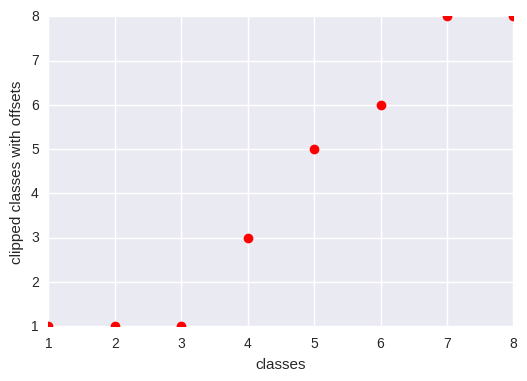

In [98]:
plt.plot(range(1,9), clip_data(np.array(range(1,9) + final_offsets), 1, 8), 'ro')
plt.xlabel('classes')
plt.ylabel('clipped classes with offsets')
plt.show()

In [54]:
# XGBoost

preds_xgb = model.predict(xgtest, ntree_limit=model.best_iteration)

offset_preds = offset_data(preds_xgb, final_offsets)
final_preds = clip_data(offset_preds, 1, 8)
score_data(final_preds, y_test)

0.6420867746929223

In [164]:
# SkLearn

preds_xgb = GBR.predict(x_test)

offset_preds = offset_data(preds_xgb, final_offsets)
final_preds = clip_data(offset_preds, 1, 8)
score_data(final_preds, y_test)

0.645914075975828

### Lasso

In [153]:
from sklearn.linear_model import LassoCV

alphas = [0.2, 0.1, 0.05, 0.01, 0.001, 0.005, 0.0001]
lasso = LassoCV(alphas=alphas)
lasso.fit(x_train, y_train)

lasso_predictions = np.round(lasso.predict(x_test))
lasso_predictions = [np.minimum(np.maximum(p, 1), 8) for p in lasso_predictions]
quadratic_weighted_kappa(lasso_predictions, y_test)

0.5300935852312663

### RidgeCV

In [64]:
from sklearn.linear_model import RidgeCV

alphas = [5,10,15,20]
ridge = RidgeCV(alphas=alphas, cv=10)
ridge.fit(x_train, y_train)

ridge_predictions = np.round(ridge.predict(x_test))
ridge_predictions = [np.minimum(np.maximum(p, 1), 8) for p in ridge_predictions]
quadratic_weighted_kappa(ridge_predictions, y_test)

0.5350644580601056

### RandomForestRegressor

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

RFR = RandomForestRegressor(n_estimators=100)

grid_params = {
    'max_depth': [2,4,6,8],
    'min_samples_leaf': [3,5,9,17],
    'max_features': [1.0,0.3,0.1]
}

grid_search = GridSearchCV(RFR, param_grid=grid_params)
grid_search.fit(x_test, y_test)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [1.0, 0.3, 0.1], 'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [3, 5, 9, 17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [66]:
RFR_predictions = np.round(grid_search.predict(x_test))
RFR_predictions = [np.minimum(np.maximum(p, 1), 8) for p in RFR_predictions]
quadratic_weighted_kappa(RFR_predictions, y_test)

0.5512278654168246

### Summary or algorithms' scores

LASSO <br/>
-> 0.5517 <br/>

RIDGE <br/>
-> 0.54179 <br/>

RFR <br/>
-> 0.56167 <br/>

GBR <br/>
-> 0.592721 <br/>
lasso features-> 0.591397196 <br/>
reduced_freq_map (reducing 1 hot enc) -> 0.59547 <br/>
no high NA features -> 0.562275 <br/>
make_binary -> 0.59283 / 0.56 <br/>
normalization -> 0.55816302 / 0.597768 <br/>
log(skewed_features) -> 0.57484 <br/>
PCA for Family_Hist -> 0.601676 <br/>
polynomials of corr featues -> 0.55/0.57/0.59 ?? <br/>
remove low var features -> 0.565397 <br/>
offsets -> 0.651096 <br/>
offsets + PCA -> 0.6530998 <br/>
offsets + PCA + lasso_cols -> ~0.65 <br/>

XGBoost <br/>
offsets -> 0.64358 <br/>

### Submit

In [176]:
GBR.fit(pd.concat([x_train, x_test]), pd.concat([y_train, y_test]))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=0.2,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=17, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=11, subsample=1.0, verbose=0,
             warm_start=False)

In [177]:
test_dataset_raw = pd.read_csv("test.csv") 
test_dataset = test_dataset_raw.copy()

In [178]:
test_dataset = test_dataset.drop('Id', axis=1)

In [179]:
test_dataset = PCA_features(test_dataset, ['Family_Hist_2', 'Family_Hist_4'], pca_fh24, scaler_fh24, drop_orig=False)
test_dataset = factorize_pr_info_2(test_dataset)
test_dataset = sum_bool_cols(test_dataset, 'Medical_Keyword')
test_dataset = test_dataset.fillna(test_dataset.mean())
test_dataset = test_dataset[lasso_cols]

In [208]:
# XGBoost

xgtest_dataset = xgb.DMatrix(test_dataset)
preds_xgb_test = model.predict(xgtest_dataset, ntree_limit=model.best_iteration)

offset_preds = offset_data(preds_xgb_test, final_offsets)
submit_preds = clip_data(offset_preds, 1, 8)

In [180]:
# SkLearn

preds_test = GBR.predict(test_dataset)

offset_preds = offset_data(preds_test, final_offsets)
submit_preds = clip_data(offset_preds, 1, 8)

In [181]:
submission = pd.DataFrame({
    "Id": test_dataset_raw['Id'],
    "Response": submit_preds
})

submission.to_csv("insurance_11.csv", index=False)